#Regression
This Jupyter Notebook shows how to use PyTorch and TensorFlow to build linear regression model. We will generate the data first, then build linear model separately

In [83]:
import random
import math
from IPython import display
from matplotlib import pyplot as plt

In [84]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


##Linear Model with PyTorch

###Data Generation

In [85]:
import torch
from torch import nn, optim

Shapes:
X: (100, 1)
y: (100, 1)


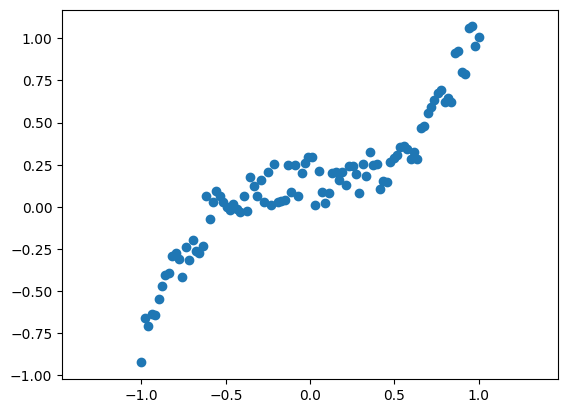

In [86]:
def data_gen(device):
    X = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1).to(device)
    y = X.pow(3) + 0.3 * torch.rand(X.size()).to(device)

    print("Shapes:")
    print("X:", tuple(X.size()))
    print("y:", tuple(y.size()))

    plt.scatter(X.cpu().numpy(), y.cpu().numpy())
    plt.axis('equal');

    return X, y

X, y = data_gen(device)


###One-Layer Model

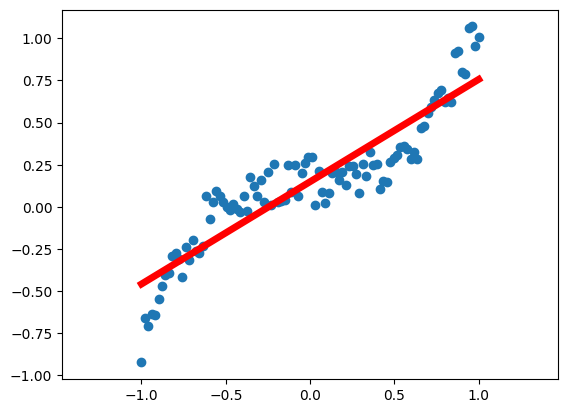

In [87]:
def train(device, D=1, H=100, C=1, learning_rate=1e-3, lambda_l2=1e-5):
    # nn package to create our linear model
    # each Linear module has a weight and bias
    model = nn.Sequential(
        nn.Linear(D, H),
        nn.Linear(H, C)
    ).to(device)

    # nn package also has different loss functions.
    # we use MSE loss for our regression task
    criterion = torch.nn.MSELoss()

    # we use the optim package to apply
    # stochastic gradient descent for our parameter updates
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

    # Training
    for t in range(1000):
        # Feed forward to get the logits
        y_pred = model(X)

        # Compute the loss (MSE)
        loss = criterion(y_pred, y)
        print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss.item()))
        display.clear_output(wait=True)

        # Zero the gradients before running the backward pass.
        optimizer.zero_grad()

        # Backward pass to compute the gradient of loss w.r.t our learnable params.
        loss.backward()

        # Update params
        optimizer.step()

    # Plot the model
    plt.scatter(X.data.cpu().numpy(), y.data.cpu().numpy())
    plt.plot(X.data.cpu().numpy(), y_pred.data.cpu().numpy(), 'r-', lw=5)
    plt.axis('equal');

    return model

model = train(device, D=1, H=100, C=1, learning_rate=1e-3, lambda_l2=1e-5)

###Two-Layers Model

In [102]:
def train(device, n_networks, models, y_pretrain, criterion, D=1, H=100, C=1, learning_rate=1e-3, lambda_l2=1e-5):
    # nn package to create our linear model
    # each Linear module has a weight and bias
    for mod in range(n_networks):
        # nn package to create our linear model
        # each Linear module has a weight and bias
        model = nn.Sequential(
            nn.Linear(D, H),
            nn.ReLU() if mod < n_networks // 2 else nn.Tanh(),
            nn.Linear(H, C)
        )
        model.to(device)

        # Append models
        models.append(model)

        # we use the optim package to apply
        # ADAM for our parameter updates
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=lambda_l2) # built-in L2

        # Training
        for t in range(1000):
            # Feed forward to get the logits
            y_pred = model(X)

            # Append pre-train output
            if t == 0:
                y_pretrain.append(y_pred.detach())

            # Compute the loss and accuracy
            loss = criterion(y_pred, y)
            if t % 200 == 0:
                print(f"[MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss.item():.6f}")
            #display.clear_output(wait=True)

            # zero the gradients before running
            # the backward pass.
            optimizer.zero_grad()

            # Backward pass to compute the gradient
            # of loss w.r.t our learnable params.
            loss.backward()

            # Update params
            optimizer.step()

        # Plot the model
        plt.scatter(X.cpu().numpy(), y.cpu().numpy())
        plt.plot(X.cpu().numpy(), y_pred.detach().cpu().numpy(), 'r-', lw=5)
        plt.axis('equal')
        plt.show()
    return models

[MODEL]: 1, [EPOCH]: 0, [LOSS]: 0.196709
[MODEL]: 1, [EPOCH]: 200, [LOSS]: 0.013617
[MODEL]: 1, [EPOCH]: 400, [LOSS]: 0.007862
[MODEL]: 1, [EPOCH]: 600, [LOSS]: 0.006748
[MODEL]: 1, [EPOCH]: 800, [LOSS]: 0.006419


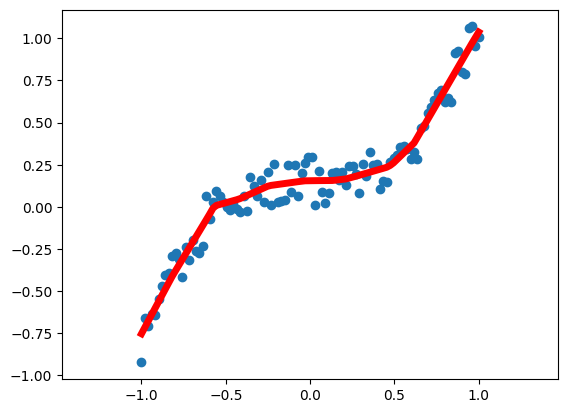

[MODEL]: 2, [EPOCH]: 0, [LOSS]: 0.154010
[MODEL]: 2, [EPOCH]: 200, [LOSS]: 0.010320
[MODEL]: 2, [EPOCH]: 400, [LOSS]: 0.006877
[MODEL]: 2, [EPOCH]: 600, [LOSS]: 0.006451
[MODEL]: 2, [EPOCH]: 800, [LOSS]: 0.006393


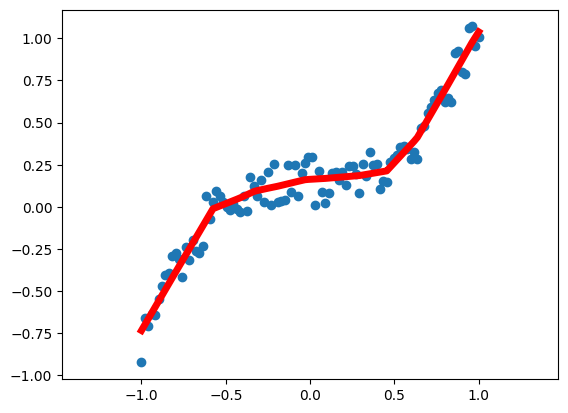

[MODEL]: 3, [EPOCH]: 0, [LOSS]: 0.191368
[MODEL]: 3, [EPOCH]: 200, [LOSS]: 0.028239
[MODEL]: 3, [EPOCH]: 400, [LOSS]: 0.024921
[MODEL]: 3, [EPOCH]: 600, [LOSS]: 0.019979
[MODEL]: 3, [EPOCH]: 800, [LOSS]: 0.011901


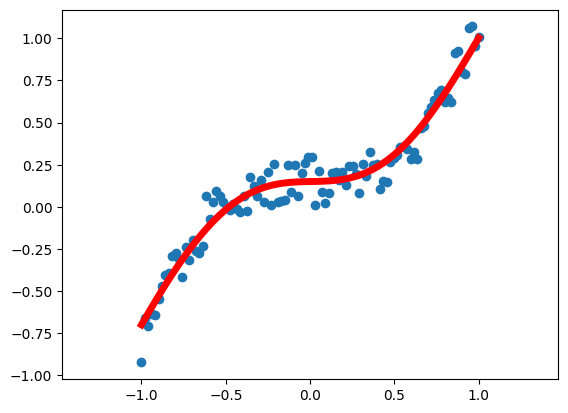

[MODEL]: 4, [EPOCH]: 0, [LOSS]: 0.425908
[MODEL]: 4, [EPOCH]: 200, [LOSS]: 0.027834
[MODEL]: 4, [EPOCH]: 400, [LOSS]: 0.025080
[MODEL]: 4, [EPOCH]: 600, [LOSS]: 0.020293
[MODEL]: 4, [EPOCH]: 800, [LOSS]: 0.013038


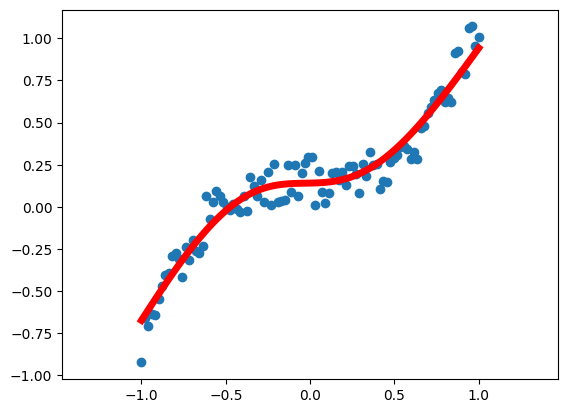

In [104]:
criterion = torch.nn.MSELoss()
models = []
y_pretrain = []
models = train(device, 4, models, y_pretrain, criterion)

###Predictions: Before Training

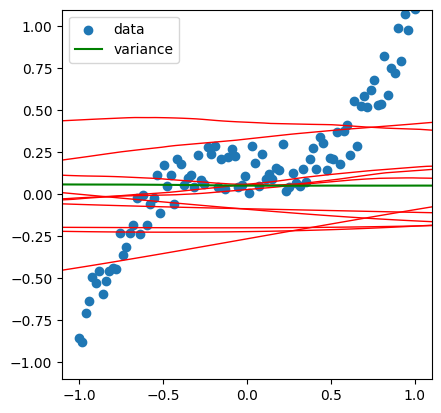

In [72]:
for y_pretrain_idx in y_pretrain:
    # New X that ranges from -5 to 5 instead of -1 to 1
    X_new = torch.unsqueeze(torch.linspace(-2, 2, 100), dim=1)

    plt.plot(X_new.numpy(), y_pretrain_idx.cpu().numpy(), 'r-', lw=1)

plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
plt.axis('square')
plt.axis((-1.1, 1.1, -1.1, 1.1));
y_combo = torch.stack(y_pretrain)
plt.plot(X_new.numpy(), y_combo.var(dim=0).cpu().numpy(), 'g', label='variance');
plt.legend()

###Predictions: After Training

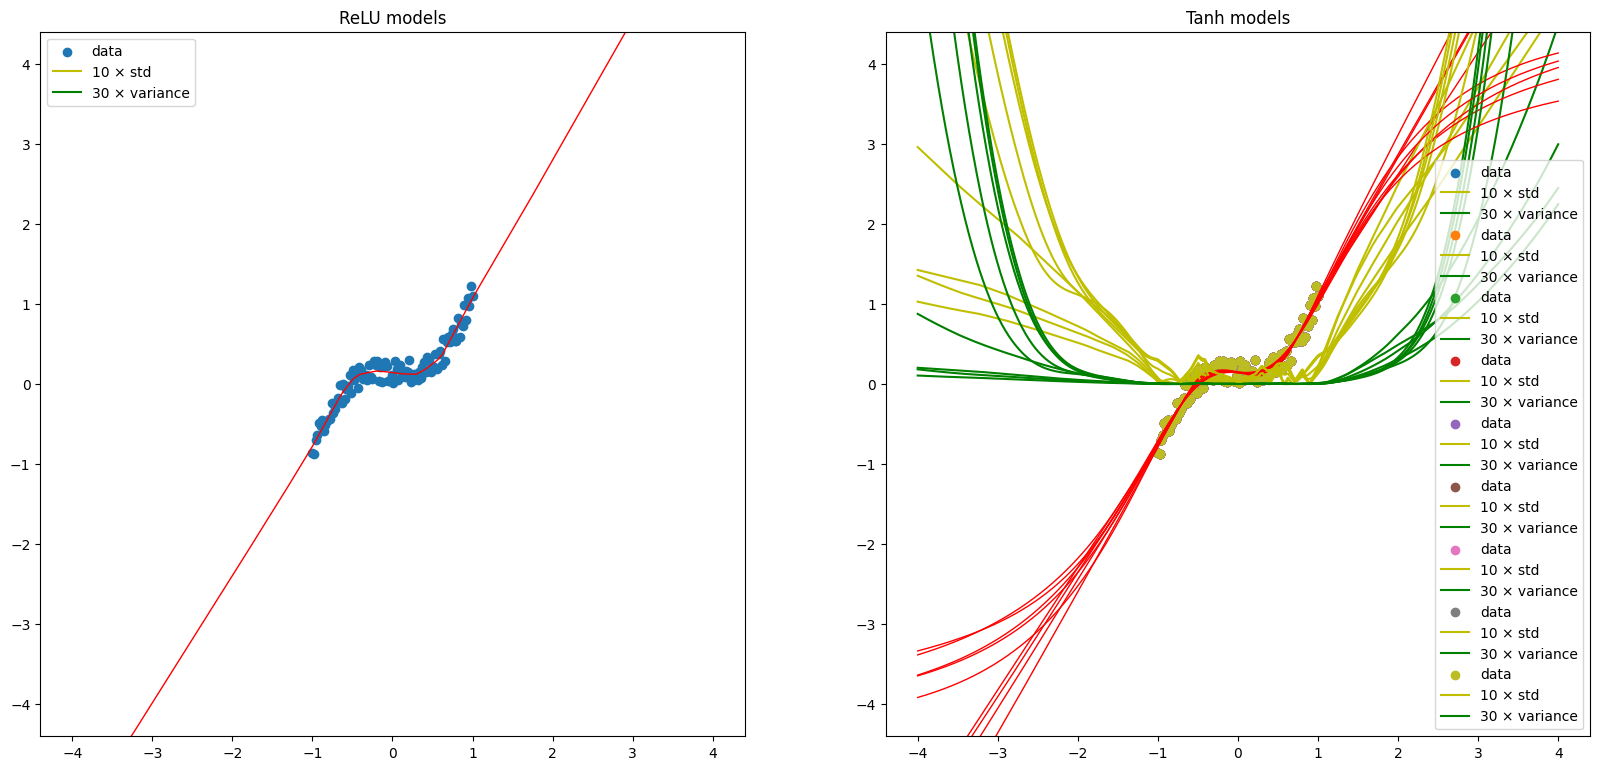

In [76]:
n_networks = 2
y_pred = list()
relu_models = models[:n_networks // 2]
tanh_models = models[n_networks // 2:]
plt.figure(figsize=(20, 10))

def dense_prediction(models, non_linearity, zoom):
    plt.subplot(1, 2, 1 if non_linearity == 'ReLU' else 2)
    for model in models:
        # New X that ranges from -5 to 5 instead of -1 to 1
        X_new = torch.unsqueeze(torch.linspace(-4, 4, 1001), dim=1).to(device)

        # Getting predictions from input
        with torch.no_grad():
            y_pred.append(model(X_new))

        plt.plot(X_new.cpu().numpy(), y_pred[-1].cpu().numpy(), 'r-', lw=1)
        plt.scatter(X.cpu().numpy(), y.cpu().numpy(), label='data')
        plt.axis('square')
        plt.axis(torch.tensor((-1.1, 1.1, -1.1, 1.1)) * zoom);
        y_combo = torch.stack(y_pred)
        plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().sqrt().numpy(), 'y', label='10 × std')
        plt.plot(X_new.cpu().numpy(), 10 * y_combo.var(dim=0).cpu().numpy(), 'g', label='30 × variance')
        plt.legend()
        plt.title(non_linearity + ' models')

z = 4  # try 1 or 4
dense_prediction(relu_models, 'ReLU', zoom=z)
dense_prediction(tanh_models, 'Tanh', zoom=z)

##Linear Model with TensorFlow

In [105]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [106]:
# Check if GPU is available
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


###Data Generation

Shapes:
X: (100, 1)
y: (100, 1)


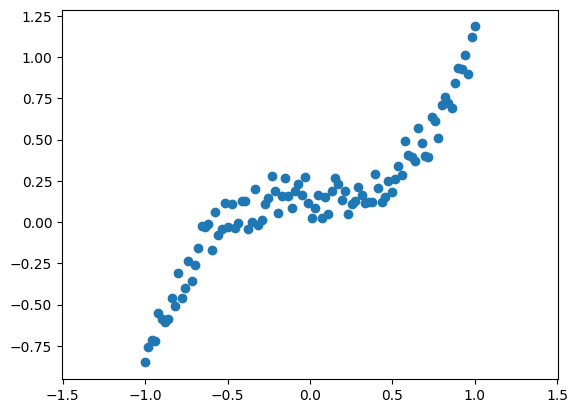

In [107]:
# Data Generation
def data_gen():
    X = tf.expand_dims(tf.linspace(-1.0, 1.0, 100), axis=1)
    y = tf.math.pow(X, 3) + 0.3 * tf.random.uniform(X.shape)

    print("Shapes:")
    print("X:", X.shape)
    print("y:", y.shape)

    plt.scatter(X.numpy(), y.numpy())
    plt.axis('equal')
    plt.show()

    return X, y

X, y = data_gen()

###One-Layer Model

[EPOCH]: 0, [LOSS or MSE]: 0.384341
[EPOCH]: 200, [LOSS or MSE]: 0.171167
[EPOCH]: 400, [LOSS or MSE]: 0.088148
[EPOCH]: 600, [LOSS or MSE]: 0.054188
[EPOCH]: 800, [LOSS or MSE]: 0.040288
4/4 [==============================] - 0s 2ms/step


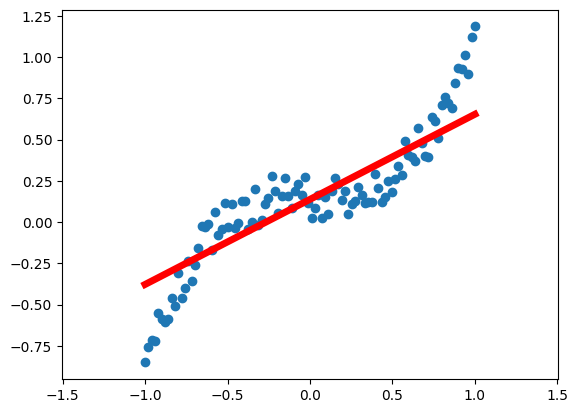

In [108]:
# Model Training
def train(D=1, H=100, C=1, learning_rate=1e-3):
    # Build the model
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(H, input_shape=(D,), activation=None),
        tf.keras.layers.Dense(C, activation=None)
    ])

    # Loss and optimizer
    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate)

    # Training loop
    for t in range(1000):
        with tf.GradientTape() as tape:
            y_pred = model(X)
            loss = loss_fn(y, y_pred)

        if t % 200 == 0:
            print("[EPOCH]: %i, [LOSS or MSE]: %.6f" % (t, loss))

        # Compute gradients and update parameters
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Plot the model
    plt.scatter(X.numpy(), y.numpy())
    plt.plot(X.numpy(), model.predict(X), 'r-', lw=5)
    plt.axis('equal')
    plt.show()

    return model

model = train(D=1, H=100, C=1, learning_rate=1e-3)

###Two-Layer Model

[MODEL]: 1, [EPOCH]: 0, [LOSS]: 0.152088
[MODEL]: 1, [EPOCH]: 200, [LOSS]: 0.014863
[MODEL]: 1, [EPOCH]: 400, [LOSS]: 0.007559
[MODEL]: 1, [EPOCH]: 600, [LOSS]: 0.006064
[MODEL]: 1, [EPOCH]: 800, [LOSS]: 0.005696


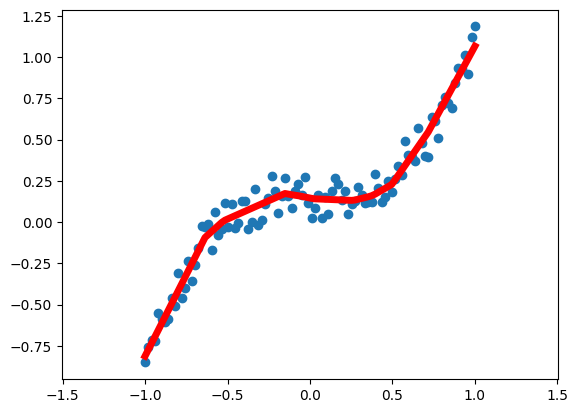

[MODEL]: 2, [EPOCH]: 0, [LOSS]: 0.134318
[MODEL]: 2, [EPOCH]: 200, [LOSS]: 0.014240
[MODEL]: 2, [EPOCH]: 400, [LOSS]: 0.006734
[MODEL]: 2, [EPOCH]: 600, [LOSS]: 0.005972
[MODEL]: 2, [EPOCH]: 800, [LOSS]: 0.005745


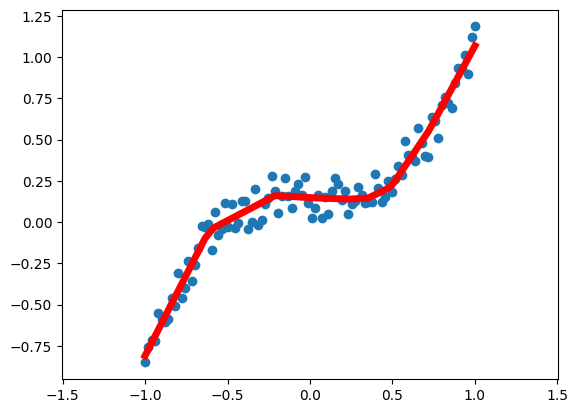

[MODEL]: 3, [EPOCH]: 0, [LOSS]: 0.174793
[MODEL]: 3, [EPOCH]: 200, [LOSS]: 0.015324
[MODEL]: 3, [EPOCH]: 400, [LOSS]: 0.007895
[MODEL]: 3, [EPOCH]: 600, [LOSS]: 0.006165
[MODEL]: 3, [EPOCH]: 800, [LOSS]: 0.005879


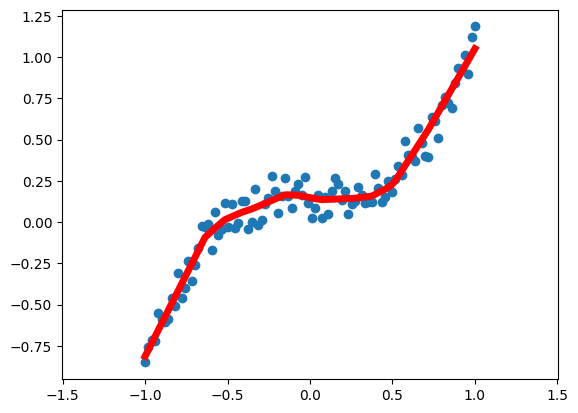

[MODEL]: 4, [EPOCH]: 0, [LOSS]: 0.149195
[MODEL]: 4, [EPOCH]: 200, [LOSS]: 0.013750
[MODEL]: 4, [EPOCH]: 400, [LOSS]: 0.007209
[MODEL]: 4, [EPOCH]: 600, [LOSS]: 0.006047
[MODEL]: 4, [EPOCH]: 800, [LOSS]: 0.005720


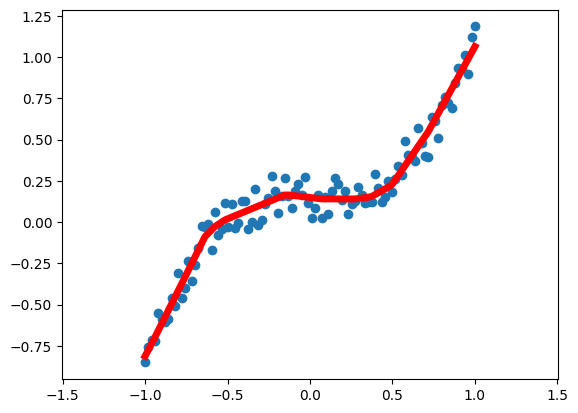

[MODEL]: 5, [EPOCH]: 0, [LOSS]: 0.246259
[MODEL]: 5, [EPOCH]: 200, [LOSS]: 0.021096
[MODEL]: 5, [EPOCH]: 400, [LOSS]: 0.010022
[MODEL]: 5, [EPOCH]: 600, [LOSS]: 0.006808
[MODEL]: 5, [EPOCH]: 800, [LOSS]: 0.006118


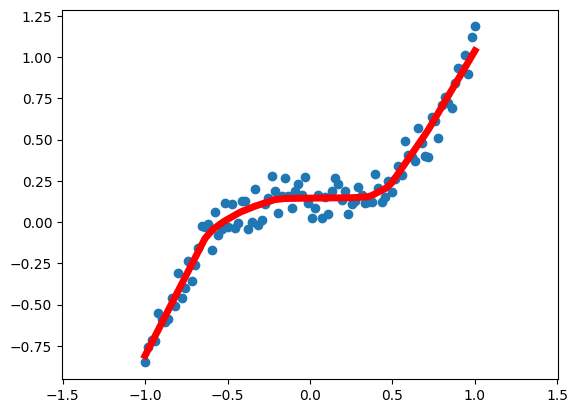

[MODEL]: 6, [EPOCH]: 0, [LOSS]: 0.207918
[MODEL]: 6, [EPOCH]: 200, [LOSS]: 0.031453
[MODEL]: 6, [EPOCH]: 400, [LOSS]: 0.031417
[MODEL]: 6, [EPOCH]: 600, [LOSS]: 0.031372
[MODEL]: 6, [EPOCH]: 800, [LOSS]: 0.031322


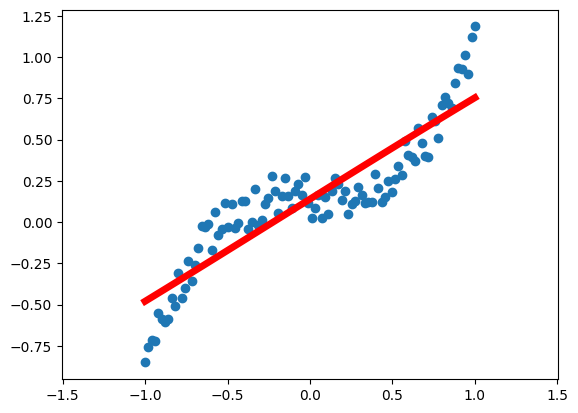

[MODEL]: 7, [EPOCH]: 0, [LOSS]: 0.118441
[MODEL]: 7, [EPOCH]: 200, [LOSS]: 0.031378
[MODEL]: 7, [EPOCH]: 400, [LOSS]: 0.031323
[MODEL]: 7, [EPOCH]: 600, [LOSS]: 0.031258
[MODEL]: 7, [EPOCH]: 800, [LOSS]: 0.031187


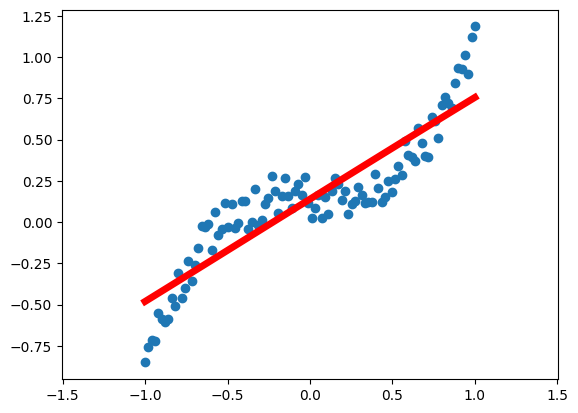

[MODEL]: 8, [EPOCH]: 0, [LOSS]: 0.051356
[MODEL]: 8, [EPOCH]: 200, [LOSS]: 0.030952
[MODEL]: 8, [EPOCH]: 400, [LOSS]: 0.024815
[MODEL]: 8, [EPOCH]: 600, [LOSS]: 0.006088
[MODEL]: 8, [EPOCH]: 800, [LOSS]: 0.006025


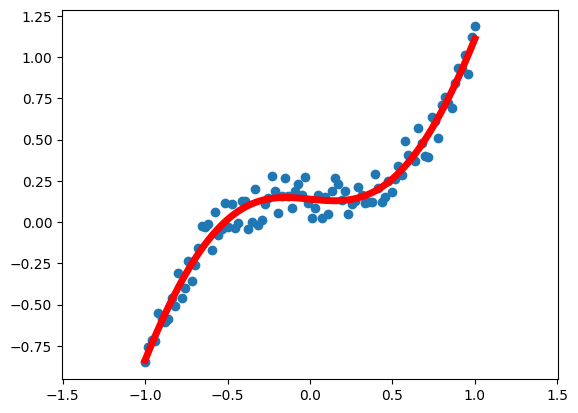

[MODEL]: 9, [EPOCH]: 0, [LOSS]: 0.473415
[MODEL]: 9, [EPOCH]: 200, [LOSS]: 0.031555
[MODEL]: 9, [EPOCH]: 400, [LOSS]: 0.031529
[MODEL]: 9, [EPOCH]: 600, [LOSS]: 0.031496
[MODEL]: 9, [EPOCH]: 800, [LOSS]: 0.031458


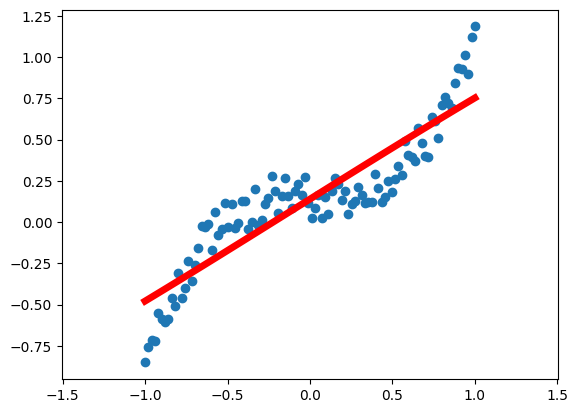

[MODEL]: 10, [EPOCH]: 0, [LOSS]: 0.274974
[MODEL]: 10, [EPOCH]: 200, [LOSS]: 0.031420
[MODEL]: 10, [EPOCH]: 400, [LOSS]: 0.031392
[MODEL]: 10, [EPOCH]: 600, [LOSS]: 0.031357
[MODEL]: 10, [EPOCH]: 800, [LOSS]: 0.031317


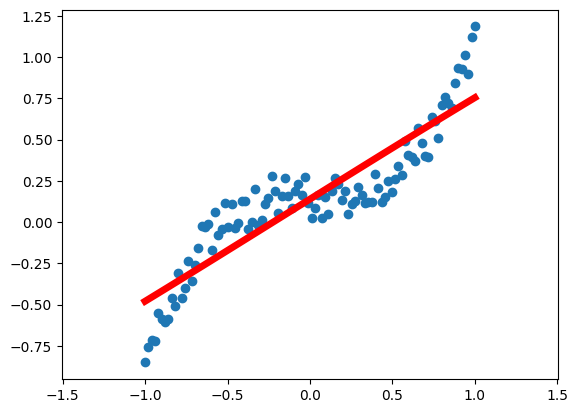

In [109]:
# Model Training
def train(n_networks, models, y_pretrain, D=1, H=100, C=1, learning_rate=1e-3, lambda_l2=1e-5):
    for mod in range(n_networks):
        # Build the model
        if mod < n_networks // 2:
            activation_func = tf.keras.activations.relu
        else:
            activation_func = tf.keras.activations.tanh

        model = tf.keras.Sequential([
            tf.keras.layers.Dense(H, input_shape=(D,), activation=None),
            tf.keras.layers.Activation(activation_func),
            tf.keras.layers.Dense(C, activation=None)
        ])

        # Loss and optimizer
        loss_fn = tf.keras.losses.MeanSquaredError()
        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

        # Training loop
        for t in range(1000):
            with tf.GradientTape() as tape:
                y_pred = model(X)
                loss = loss_fn(y, y_pred)
                loss += lambda_l2 * tf.reduce_sum([tf.reduce_sum(tf.square(w)) for w in model.trainable_variables])

            if t == 0:
                y_pretrain.append(y_pred.numpy())

            if t % 200 == 0:
                print(f"[MODEL]: {mod + 1}, [EPOCH]: {t}, [LOSS]: {loss:.6f}")

            # Compute gradients and update parameters
            grads = tape.gradient(loss, model.trainable_variables)
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Append the trained model to the list
        models.append(model)

        # Plot the model
        plt.scatter(X.numpy(), y.numpy())
        plt.plot(X.numpy(), y_pred.numpy(), 'r-', lw=5)
        plt.axis('equal')
        plt.show()

    return models

# Initialize variables
n_networks = 10
models = []
y_pretrain = []

# Train models
trained_models = train(n_networks, models, y_pretrain)
